# InfluxDB 
InfluxDB ist eine Zeitreihen-Datenbank, die speziell für das Sammeln, Speichern und Abfragen von Zeitreihen-Daten entwickelt wurde.
Sie gehört zum Typ der NoSQL-Datenbanken und basiert auf dem Konzept der Kapazitätsplanung.



## Verwendung
InfluxDB wird hauptsächlich für die Überwachung und Analyse von Zeitreihen-Daten verwendet, insbesondere in Bereichen wie IoT, Anwendungsüberwachung und Netzwerküberwachung.

Die Stärken von InfluxDB liegen in seiner hohen Leistung bei der Verarbeitung von Zeitreihen-Daten, seiner einfachen Handhabung und seiner integrierten Unterstützung
für Anfragen in der Abfragesprache SQL. Einige Schwächen sind jedoch die begrenzte Skalierbarkeit und die fehlende Unterstützung für Transaktionen.

# Weitere infos
Es ist auch wichtig zu beachten, dass InfluxDB ein Teil der TICK-Stack-Suite von InfluxData ist, die auch Telegraf (für die Datenerfassung), Chronograf (für die Visualisierung) und Kapacitor (für die automatisierte Verarbeitung) umfasst. Diese Tools können zusammen verwendet werden, um eine vollständige Lösung für die Zeitreihenanalyse zu erhalten.

## Instalation
InfluxDB kann direkt installiert werden, indem die Installationsanleitung auf der offiziellen Website unter https://docs.influxdata.com/influxdb/v2.0/install befolgt wird. Es gibt auch die Möglichkeit, InfluxDB über Docker zu installieren, indem man den Befehl "docker pull influxdb" ausführt und die Anweisungen unter https://docs.influxdata.com/influxdb/v2.0/install/?t=Docker befolgt.




In [ ]:
docker run --name influxdb -p 8086:8086 influxdb:2.0.9

## Anwendung:


In [7]:
#!/usr/bin/python3
import pandas as pd
import json

import influxdb_client
from influxdb import DataFrameClient
from influxdb_client import InfluxDBClient, Point
from influxdb_client.client.write_api import ASYNCHRONOUS

from dateutil import parser
import requests
from string import Template

#Data Source
import yfinance as yf

create bucket and token in UI

In [16]:
bucket = "DSI_test"
token ="yxk8_Or5qHZJxrhJE3SkAnTQSViQCsmrUoR0xPZd_0scy1T8FTuL1cKSTDKh1ft8Bqs3Zbt7Rwkys-FzajIVFQ=="
org="DSI"
client = InfluxDBClient(url="http://localhost:8086", token=token, org=org)

In [5]:
#Interval required 1 minute IBM
df_IBM = yf.download(tickers='IBM', period='1d', interval='1m')
df_IBM

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2023-01-25 09:30:00-05:00,140.470001,140.559906,140.149994,140.210007,140.210007,103607
2023-01-25 09:31:00-05:00,140.100006,140.160004,139.600006,139.889999,139.889999,44256
2023-01-25 09:32:00-05:00,139.889999,139.892395,139.600006,139.800003,139.800003,6349
2023-01-25 09:33:00-05:00,139.809998,139.889999,139.740005,139.876999,139.876999,9378
2023-01-25 09:34:00-05:00,139.880005,140.000000,139.850006,139.940002,139.940002,19800
...,...,...,...,...,...,...
2023-01-25 15:56:00-05:00,140.500000,140.524994,140.500000,140.524994,140.524994,78200
2023-01-25 15:57:00-05:00,140.529999,140.600006,140.524994,140.595001,140.595001,63515
2023-01-25 15:58:00-05:00,140.600006,140.600006,140.520004,140.580002,140.580002,91082


write yahoo finance data in DB

In [9]:
with client.write_api(write_options=ASYNCHRONOUS) as writer:
    writer.write(
        bucket=bucket,
        record=df_IBM,
        data_frame_measurement_name="IBM",
        data_frame_tag_columns=["symbol"],
        data_frame_field_columns=["open", "high", "low", "close", "volume"]
        )

Query the Data

In [25]:

query_api = client.query_api()

query = """from(bucket: "DSI_test")
  |> range(start:-1d)
  |> filter(fn: (r) => r["_measurement"] == "IBM")
  |> filter(fn: (r) => r["_field"] == "Volume")"""

result = query_api.query(org=org, query=query)

results = []
for table in result:
    for record in table.records:
        results.append((record.get_time(), record.get_measurement(), record.get_field(), record.get_value()))

#make a dataframe from the results

df = pd.DataFrame(results, columns=['Date',"Symbol", 'OHLC', "Value"])
df['Date'] = pd.to_datetime(df['Date'])
#if OHLC is Open, High, Low, or Close, then make it a column
df = df.pivot(index='Date', columns='OHLC', values='Value')

df

OHLC,Volume
Date,
2023-01-25 14:39:00+00:00,14832
2023-01-25 14:40:00+00:00,12650
2023-01-25 14:41:00+00:00,12744
2023-01-25 14:42:00+00:00,5209
2023-01-25 14:43:00+00:00,10381
...,...
2023-01-25 20:56:00+00:00,78200
2023-01-25 20:57:00+00:00,63515
2023-01-25 20:58:00+00:00,91082


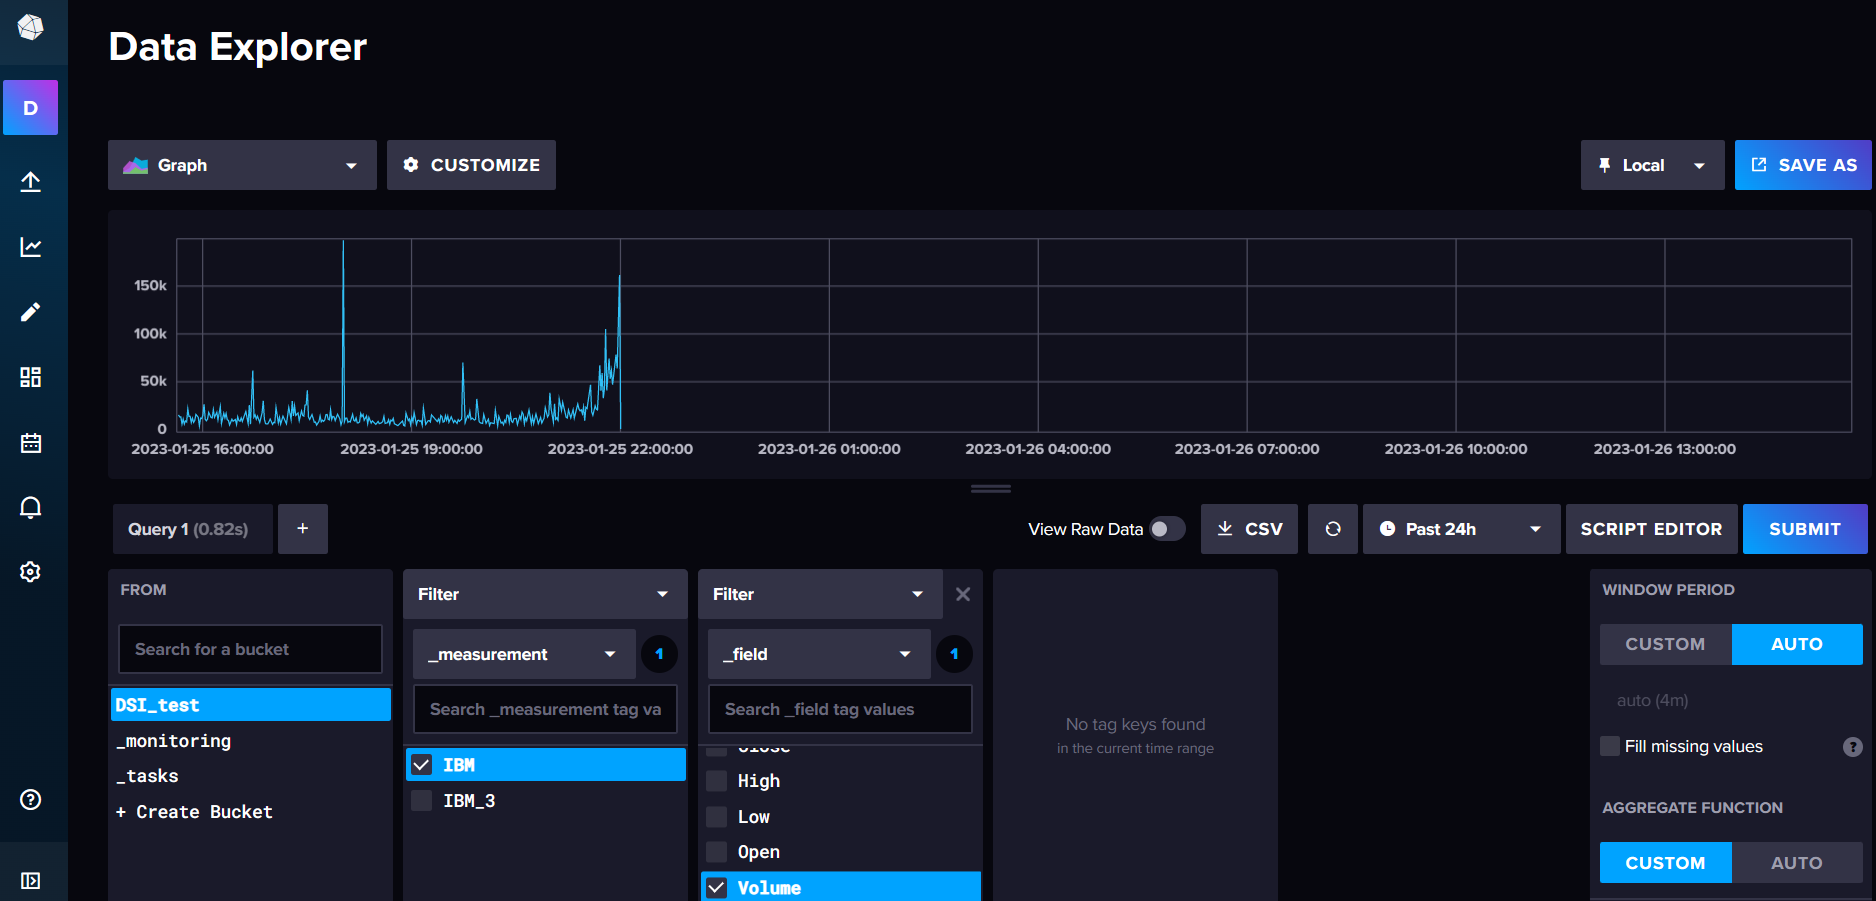

In [1]:
# UI_example.png


from IPython import display
display.Image("UI_example.png")